In [82]:
from utils import * 
import numpy as np

URL = "http://mtg.upf.edu/static/datasets/last.fm/lastfm-dataset-1K.tar.gz"
f_name = "lastfm-dataset-1K.tar.gz"
dir_name = "lastfm-dataset-1K"
dataset_f_name = "userid-timestamp-artid-artname-traid-traname.tsv"

In [83]:
download_dataset(URL, f_name)

Dataset Exists...


In [84]:
user_data = load_dataset(dir_name, dataset_f_name, 1000000)

Read File...


In [85]:
user_data[:10]

,userid,timestamp,artist-id,artist-name,track-id,track-name
0,user_000001,2009-05-04T23:08:57Z,f1b1cf71-bd35-4e99-8624-24a6e15f133a,Deep Dish,NaN,Fuck Me Im Famous (Pacha Ibiza)-09-28-2007
1,user_000001,2009-05-04T13:54:10Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Composition 0919 (Live_2009_4_15)
2,user_000001,2009-05-04T13:52:04Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Mc2 (Live_2009_4_15)
3,user_000001,2009-05-04T13:42:52Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Hibari (Live_2009_4_15)
4,user_000001,2009-05-04T13:42:11Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Mc1 (Live_2009_4_15)
5,user_000001,2009-05-04T13:38:31Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,To Stanford (Live_2009_4_15)
6,user_000001,2009-05-04T13:33:28Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Improvisation (Live_2009_4_15)
7,user_000001,2009-05-04T13:23:45Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Glacier (Live_2009_4_15)
8,user_000001,2009-05-04T13:19:22Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Parolibre (Live_2009_4_15)
9,user_000001,2009-05-04T13:13:38Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Bibo No Aozora (Live_2009_4_15)


## Cleaning infrequent data

First remove infrequent tracks (<10 plays)

In [86]:
# Removing infrequent tracks.
if user_data['track-id'].isnull().sum() > 0:
    user_data = user_data.dropna(axis = 0, subset = ['track-id'])

In [87]:
user_data.shape

(865616, 6)

In [88]:
total_plays = user_data.groupby(["track-id"]).size().reset_index()
total_plays.rename(columns = {0: 'total'}, inplace = True)
total_plays.describe()

,total
count,126986.000000
mean,6.816625
std,25.337567
min,1.000000
25%,1.000000
50%,2.000000
75%,6.000000
max,2069.000000


In [89]:
frequent_plays = total_plays[total_plays['total'] >= 10]['track-id']
frequent_plays.describe()

count                                    20666
unique                                   20666
top       8837c142-45e4-495f-abd9-4f3c016dfa52
freq                                         1
Name: track-id, dtype: object

In [90]:
# Drop infrequent tracks.
data = user_data[user_data['track-id'].isin(frequent_plays)]
data.describe()

,userid,timestamp,artist-id,artist-name,track-id,track-name
count,595039,595039,595039,595039,595039,595039
unique,41,592738,3331,3309,20666,19328
top,user_000033,2008-11-24T11:38:21Z,164f0d73-1234-4e2c-8743-d77bf2191051,Kanye West,82558949-cd98-4c58-af35-3f1a9430d52e,Heartless
freq,58772,24,26616,26616,2069,2120


Now, remove infrequent users.

In [91]:
# Removing infrequent tracks.
if data['userid'].isnull().sum() > 0:
    data = data.dropna(axis = 0, subset = ['userid'])

In [92]:
data.shape

(595039, 6)

In [93]:
user_plays = data.groupby(["userid"]).size().reset_index()
user_plays.rename(columns = {0: 'total'}, inplace = True)
user_plays.describe()

,total
count,41.000000
mean,14513.146341
std,15059.907282
min,176.000000
25%,3090.000000
50%,10437.000000
75%,18144.000000
max,58772.000000


In [94]:
frequent_users = user_plays[user_plays['total'] >= 10]['userid']
frequent_users.describe()

count              41
unique             41
top       user_000035
freq                1
Name: userid, dtype: object

In [95]:
# Drop infrequent tracks.
data = data[data['userid'].isin(frequent_users)]
data.describe()

,userid,timestamp,artist-id,artist-name,track-id,track-name
count,595039,595039,595039,595039,595039,595039
unique,41,592738,3331,3309,20666,19328
top,user_000033,2008-11-24T11:38:21Z,164f0d73-1234-4e2c-8743-d77bf2191051,Kanye West,82558949-cd98-4c58-af35-3f1a9430d52e,Heartless
freq,58772,24,26616,26616,2069,2120


## Listening Sessions

We create listening sessions for the ground-truth of top-n recommendations and for song2vec

In [96]:
user_play_counts=data.groupby(["userid"]).size().to_frame('size').reset_index()
user_play_counts

,userid,size
0,user_000001,6723
1,user_000002,42930
2,user_000003,10437
3,user_000004,8200
4,user_000005,13211
5,user_000006,10246
6,user_000007,182
7,user_000008,34997
8,user_000009,1857
9,user_000010,3090


In [97]:
groups=data.groupby('userid')
groups.groups

{'user_000001': Int64Index([   10,    12,    14,    15,    74,   174,   255,   256,   257,
               258,
             ...
             16653, 16654, 16655, 16659, 16667, 16669, 16676, 16682, 16683,
             16684],
            dtype='int64', length=6723),
 'user_000002': Int64Index([16685, 16686, 16696, 16697, 16698, 16704, 16705, 16708, 16710,
             16711,
             ...
             74112, 74113, 74114, 74115, 74117, 74118, 74119, 74120, 74121,
             74122],
            dtype='int64', length=42930),
 'user_000003': Int64Index([74127, 74128, 74144, 74147, 74161, 74163, 74164, 74165, 74166,
             74167,
             ...
             93602, 93603, 93605, 93606, 93611, 93612, 93613, 93614, 93615,
             93616],
            dtype='int64', length=10437),
 'user_000004': Int64Index([ 93622,  93627,  93635,  93637,  93638,  93639,  93648,  93649,
              93650,  93651,
             ...
             112007, 112008, 112010, 112016, 112019, 112020, 1

In [98]:
import datetime, dateutil.parser
sessions = []
sessions_user = []
for user, indices in groups.groups.iteritems():
    print("------------------------------------------ User ",user)
    user_record = data.loc[indices, :].sort_values(['timestamp'])
    print user_record.shape
#     print user_record.index
    session = [user_record.iloc[0].name]
    for i in range(0, user_record.shape[0] - 1):
        d1 = int(dateutil.parser.parse(user_record.iloc[i]['timestamp']).strftime('%s'))
        d2 = int(dateutil.parser.parse(user_record.iloc[i+1]['timestamp']).strftime('%s'))
        if(d2-d1 < 800 ):
            session.append(user_record.iloc[i+1].name)
        else:
            if(len(session)>10):
                sessions.append(session)
                sessions_user.append(user)
            session=[]
            session.append(user_record.iloc[i+1].name)
    

('------------------------------------------ User ', 'user_000038')
(7167, 6)
('------------------------------------------ User ', 'user_000039')
(11142, 6)
('------------------------------------------ User ', 'user_000036')
(1471, 6)
('------------------------------------------ User ', 'user_000037')
(2875, 6)
('------------------------------------------ User ', 'user_000034')
(11816, 6)
('------------------------------------------ User ', 'user_000035')
(1213, 6)
('------------------------------------------ User ', 'user_000032')
(12093, 6)
('------------------------------------------ User ', 'user_000033')
(58772, 6)
('------------------------------------------ User ', 'user_000030')
(10939, 6)
('------------------------------------------ User ', 'user_000031')
(12135, 6)
('------------------------------------------ User ', 'user_000014')
(176, 6)
('------------------------------------------ User ', 'user_000015')
(10161, 6)
('------------------------------------------ User ', 'user

## Storing id-name mappings

Forming an artist, track id-name mapping.

In [99]:
artists = data[["artist-id", "artist-name"]].drop_duplicates()


In [100]:
track = data[["track-id", "track-name"]].drop_duplicates()

Forming a mapping from artist to track

In [101]:
artist_track = data[["track-id", "artist-id"]].drop_duplicates()

## Playcount matrix

In [102]:
playcount = data.groupby(["userid", "track-id"]).size().reset_index()

In [103]:
playcount.rename(columns = {0: 'playcount'}, inplace = True)

In [104]:
playcount[:10]

,userid,track-id,playcount
0,user_000001,00b07689-ec4c-4773-94ce-06f3d198431e,4
1,user_000001,0198d56b-a92f-4596-a206-9e136f56e39f,21
2,user_000001,019cc5d9-1aaf-4687-b0af-6bc83bbccf0b,16
3,user_000001,01d866fc-7145-46af-ad7a-4133a477d54b,6
4,user_000001,02d30185-9d38-4f1c-9dac-63aa14f8cc69,1
5,user_000001,03156214-005e-456f-a5e3-0df32024fdad,16
6,user_000001,04049f3b-2fda-460f-a3ea-05f0418792c1,13
7,user_000001,04be389b-e44f-46c3-9ff3-2a0f0c3beda7,12
8,user_000001,05182b53-d942-4e39-9d87-3e62658898ff,14
9,user_000001,05ef9a7c-edab-4937-9c46-6bf572017d14,17


In [105]:
from scipy.sparse import csr_matrix

playcounts = playcount.pivot(index = 'userid', columns = 'track-id', values = 'playcount').fillna(0)


In [106]:
plays_matrix = csr_matrix(playcounts.values)
playcounts[:10]

track-id,0002c0b8-b737-49d8-a007-68d3bc2da175,0003dd36-b4d2-4216-a37e-b110f6882ecb,0005ebe2-6971-4de6-a8eb-5dff41f3b811,00063d3a-14a8-4748-8025-4b7cb828b37f,00087784-820c-4f71-b539-1f948b37befe,0019e275-6d9f-4ff8-bcd8-1bfce804163a,002017be-b745-42e4-aaf2-74a1c3879703,00226a83-ec86-4950-83de-650c3715e344,00271b0b-0459-4984-a3a5-a1f88e1136ca,002a1ae6-34bf-4687-b2ff-f78aaf7c74f5,...,ffddf0b4-d265-40e1-8950-f97207e86838,ffe2102d-4a5e-48b7-977a-0c28e2af119e,ffe3798a-44fd-4795-969c-2e14fc7083c8,ffea36e9-ae42-402d-ba47-2c1ef4cfca05,ffeaac69-dfd9-4159-950f-3981d5775b91,fff02100-41bf-440f-bcb8-f8998b6b1cc7,fff1607f-8763-460f-bf46-44da9c95a93a,fff7464a-d5db-4dd7-9c40-9e8deddf6063,fffada82-2845-44a0-a783-899f383e295e,fffe453c-b68b-4e43-9cef-b6767a587415
userid,,,,,,,,,,,,,,,,,,,,,
user_000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
user_000002,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0
user_000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
user_000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
user_000005,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
user_000006,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
user_000007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
user_000008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
user_000009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Conversion of Playcounts to Ratings

Based on work in A hybrid online-product recommendation system: Combining implicit
rating-based collaborative filtering and sequential pattern analysis by Choi et al.

Absolute Preference: AP(u, i) = ln((n(u played i)/n(u played anything)) + 1)

Relative Preference: RP(u, i) = AP(u,i) / Max_{c \in U} AP(c, i)

Implicit Rating: R(u, i) = Round up(5 * RP (u,i))

In [107]:
# List of number of songs ever played by each user. Reduces computation
user_plays = plays_matrix.sum(axis=1) # Sum all columns
print(user_plays[:20])
print(user_plays.shape)

#number_of_users

[[  6723.]
 [ 42930.]
 [ 10437.]
 [  8200.]
 [ 13211.]
 [ 10246.]
 [   182.]
 [ 34997.]
 [  1857.]
 [  3090.]
 [  3700.]
 [ 47121.]
 [  4220.]
 [   176.]
 [ 10161.]
 [ 11517.]
 [  3810.]
 [ 10566.]
 [ 22334.]
 [  2793.]]
(41, 1)


In [108]:
# Compute Absolute Rating
absolute_preferences = np.log(plays_matrix / user_plays + 1)

In [109]:
absolute_preferences.shape
n_users=absolute_preferences.shape[0]
n_items=absolute_preferences.shape[1]

In [110]:
# 2. List of maximum ratings of each item
max_ratings = absolute_preferences.max(axis=0) # Along columns
print(max_ratings[:10])
print(max_ratings.shape)

[[ 0.00077131  0.00054501  0.00105916 ...,  0.00215983  0.00067887
   0.00037263]]
(1, 20666)


In [111]:
print(max_ratings[max_ratings ==0].size)

0


In [112]:
print(user_plays[user_plays == 0].size)

0


In [113]:
print(max_ratings.shape)

(1, 20666)


In [114]:
# Relative Preference: RP(u, i) = AP(u,i) / Max_{c \in U} AP(c, i)
relative_preferences = absolute_preferences / (max_ratings)
print(absolute_preferences.shape)
print(relative_preferences.shape)

(41, 20666)
(41, 20666)


In [115]:
# Implicit Rating: R(u, i) = Round up(5 * RP (u,i))
implicit_ratings = np.ceil(5 * relative_preferences)

In [116]:
implicit_ratings.max(axis=1)
print(implicit_ratings[:10, :10])

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  2.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  5.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  5.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [117]:
implicit_ratings.shape

(41, 20666)

## Test-Train Split

First, for rating matrix

In [118]:
TRAIN_SIZE = 0.80
# Create boolean mask
# np.random creates a vector of random values between 0 and 1
# Those values are filtered to create a binary mask
msk = np.random.rand(implicit_ratings.shape[0],implicit_ratings.shape[1]) < TRAIN_SIZE
r = np.zeros(implicit_ratings.shape)
print (msk.shape)
 
train_ratings = implicit_ratings.copy()
test_ratings = implicit_ratings.copy()
    
train_ratings[msk] = r[msk]
test_ratings[~msk] = r[~msk] # inverse of boolean mask

(41, 20666)


In [119]:
test_ratings[msk].shape

(1, 677604)

In [120]:
print(implicit_ratings[:6, :6])
print(train_ratings[:6, :6])
print(test_ratings[:6, :6])
print(implicit_ratings.shape)
print(train_ratings.shape)
print(test_ratings.shape)

[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  2.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  5.  0.  0.  0.]
 [ 0.  0.  5.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  2.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  5.  0.  0.  0.]
 [ 0.  0.  5.  0.  0.  0.]]
(41, 20666)
(41, 20666)
(41, 20666)


Now for listening sessions aka top-n recommendations train set is the same because we just learn the ratings and predict the best.

In [121]:
scoring_ranks = [data.loc[s, ['track-id']].values.flatten() for s in sessions]

In [122]:
len(sessions)

14346

## Metrics

We use the following metrics

### For Rating Prediction

#### Mean Absolute Error

![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/3ef87b78a9af65e308cf4aa9acf6f203efbdeded)


#### Root Mean Square Error

![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/24a21c4e87218f03bdc76d7b858b93ed448d7682)


### For Top-n Recommendations

#### Precision at k

![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/95eeb143dd5ded21c882eaa4530ec69739a3a218)

Here, documents are each record.


#### Mean Average Precision at k

![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/64788ba190d585f3837f9d10fe24f3b9689dba4b)

![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/decf93706ec7c8632fdfabe41470962101f9bcd8)

#### Truncated Normalized Discounted Cumulative Gain (NDCG@K)

![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/c7cf810f95722b0add5a9efb17b47215ada9e168)

![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/7f28a12199cde773a6897d5f3021d4e2d3b2f0fe)

In [123]:
from metrics import * 

In [124]:
#type(implicit_ratings)
ratings = np.array(implicit_ratings)
test_r = np.array(test_ratings)
train_r = np.array(train_ratings)

In [125]:
ratings

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  2.,  0., ...,  0.,  0.,  5.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  5.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [126]:
test_r

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  2.,  0., ...,  0.,  0.,  5.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [127]:
train_r

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  5.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [128]:
print (n_users)
print (n_items)
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

41
20666
Sparsity: 6.39%


In [129]:
import numpy as np
from bmf import *

In [49]:
# print(rmse)
# print(num_f)

In [50]:
num_f1=[]
rmse1=[]
it = [20, 40, 60, 80, 100]

for i in it: 
    rmse=[]
    num_f=[]
    bmf = MF(train_r, test_r, K=8, alpha=0.1, beta=0.01, iterations=i)
    training_process = bmf.train()
    rmse.append(float(bmf.mse()))
    num_f.append(bmf.K)
    
    bmf = MF(train_r, test_r, K=16, alpha=0.1, beta=0.01, iterations=i)
    training_process = bmf.train()
    rmse.append(float(bmf.mse()))
    num_f.append(bmf.K)
    
    bmf = MF(train_r, test_r, K=32, alpha=0.1, beta=0.01, iterations=i)
    training_process = bmf.train()
    rmse.append(float(bmf.mse()))
    num_f.append(bmf.K)
    
    bmf = MF(train_r, test_r, K=64, alpha=0.1, beta=0.01, iterations=i)
    training_process = bmf.train()
    rmse.append(float(bmf.mse()))
    num_f.append(bmf.K)
    
    bmf = MF(train_r, test_r, K=128, alpha=0.1, beta=0.01, iterations=i)
    training_process = bmf.train()
    rmse.append(float(bmf.mse()))
    num_f.append(bmf.K)
    rmse1.append(rmse)
    num_f1.append(num_f)
    



Iteration: 10 ; error = 1.7220
Iteration: 20 ; error = 1.7156
Iteration: 10 ; error = 1.6736
Iteration: 20 ; error = 1.6732
Iteration: 10 ; error = 1.6631
Iteration: 20 ; error = 1.6640
Iteration: 10 ; error = 1.6548
Iteration: 20 ; error = 1.6568
Iteration: 10 ; error = 1.6550
Iteration: 20 ; error = 1.6571
Iteration: 10 ; error = 1.7205
Iteration: 20 ; error = 1.7136
Iteration: 30 ; error = 1.7108
Iteration: 40 ; error = 1.7096
Iteration: 10 ; error = 1.6732
Iteration: 20 ; error = 1.6723
Iteration: 30 ; error = 1.6729
Iteration: 40 ; error = 1.6737
Iteration: 10 ; error = 1.6606
Iteration: 20 ; error = 1.6618
Iteration: 30 ; error = 1.6635
Iteration: 40 ; error = 1.6650
Iteration: 10 ; error = 1.6564
Iteration: 20 ; error = 1.6581
Iteration: 30 ; error = 1.6600
Iteration: 40 ; error = 1.6619
Iteration: 10 ; error = 1.6571
Iteration: 20 ; error = 1.6593
Iteration: 30 ; error = 1.6612
Iteration: 40 ; error = 1.6634
Iteration: 10 ; error = 1.7219
Iteration: 20 ; error = 1.7152
Iteratio

In [52]:
rmse2=[rmse1]
num_f2=[num_f1]

In [54]:
rmse2.append(rmse1)
num_f1=[]
rmse1=[]
it = [20, 40, 60, 80, 100]
a=0.05
for i in it: 
    rmse=[]
    num_f=[]
    mf = MF(train_r, test_r, K=8, alpha=a, beta=a, iterations=i)
    training_process = mf.train()
    rmse.append(float(mf.mse()))
    num_f.append(mf.K)
    mf = MF(train_r, test_r, K=16, alpha=a, beta=a, iterations=i)
    training_process = mf.train()
    rmse.append(float(mf.mse()))
    num_f.append(mf.K)
    mf = MF(train_r, test_r, K=32, alpha=a, beta=a, iterations=i)
    training_process = mf.train()
    rmse.append(float(mf.mse()))
    num_f.append(mf.K)
    mf = MF(train_r, test_r, K=64, alpha=a, beta=a, iterations=i)
    training_process = mf.train()
    rmse.append(float(mf.mse()))
    num_f.append(mf.K)
    mf = MF(train_r, test_r, K=128, alpha=a, beta=a, iterations=i)
    training_process = mf.train()
    rmse.append(float(mf.mse()))
    num_f.append(mf.K)
    rmse1.append(rmse)
    num_f1.append(num_f)
    num_f2.append(num_f1)

Iteration: 10 ; error = 1.7026
Iteration: 20 ; error = 1.6999
Iteration: 10 ; error = 1.6740
Iteration: 20 ; error = 1.6767
Iteration: 10 ; error = 1.6625
Iteration: 20 ; error = 1.6673
Iteration: 10 ; error = 1.6606
Iteration: 20 ; error = 1.6655
Iteration: 10 ; error = 1.6581
Iteration: 20 ; error = 1.6649
Iteration: 10 ; error = 1.7069
Iteration: 20 ; error = 1.7046
Iteration: 30 ; error = 1.7059
Iteration: 40 ; error = 1.7080
Iteration: 10 ; error = 1.6702
Iteration: 20 ; error = 1.6737
Iteration: 30 ; error = 1.6775
Iteration: 40 ; error = 1.6803
Iteration: 10 ; error = 1.6628
Iteration: 20 ; error = 1.6684
Iteration: 30 ; error = 1.6727
Iteration: 40 ; error = 1.6758
Iteration: 10 ; error = 1.6587
Iteration: 20 ; error = 1.6651
Iteration: 30 ; error = 1.6700
Iteration: 40 ; error = 1.6749
Iteration: 10 ; error = 1.6595
Iteration: 20 ; error = 1.6651
Iteration: 30 ; error = 1.6707
Iteration: 40 ; error = 1.6749
Iteration: 10 ; error = 1.7015
Iteration: 20 ; error = 1.7014
Iteratio

In [55]:


num_f1=[]
rmse1=[]
it = [20, 40, 60, 80, 100]
a=0.05
for i in it: 
    rmse=[]
    num_f=[]
    mf = MF(train_r, test_r, K=8, alpha=a, beta=a, iterations=i)
    training_process = mf.train()
    rmse.append(float(mf.mse()))
    num_f.append(mf.K)
    mf = MF(train_r, test_r, K=16, alpha=a, beta=a, iterations=i)
    training_process = mf.train()
    rmse.append(float(mf.mse()))
    num_f.append(mf.K)
    mf = MF(train_r, test_r, K=32, alpha=a, beta=a, iterations=i)
    training_process = mf.train()
    rmse.append(float(mf.mse()))
    num_f.append(mf.K)
    mf = MF(train_r, test_r, K=64, alpha=a, beta=a, iterations=i)
    training_process = mf.train()
    rmse.append(float(mf.mse()))
    num_f.append(mf.K)
    mf = MF(train_r, test_r, K=128, alpha=a, beta=a, iterations=i)
    training_process = mf.train()
    rmse.append(float(mf.mse()))
    num_f.append(mf.K)
    rmse1.append(rmse)
    num_f1.append(num_f)

Iteration: 10 ; error = 1.7044
Iteration: 20 ; error = 1.7028
Iteration: 10 ; error = 1.6716
Iteration: 20 ; error = 1.6739
Iteration: 10 ; error = 1.6637
Iteration: 20 ; error = 1.6693
Iteration: 10 ; error = 1.6574
Iteration: 20 ; error = 1.6633
Iteration: 10 ; error = 1.6597
Iteration: 20 ; error = 1.6663
Iteration: 10 ; error = 1.7067
Iteration: 20 ; error = 1.7058
Iteration: 30 ; error = 1.7076
Iteration: 40 ; error = 1.7088
Iteration: 10 ; error = 1.6732
Iteration: 20 ; error = 1.6762
Iteration: 30 ; error = 1.6796
Iteration: 40 ; error = 1.6831
Iteration: 10 ; error = 1.6648
Iteration: 20 ; error = 1.6695
Iteration: 30 ; error = 1.6744
Iteration: 40 ; error = 1.6780
Iteration: 10 ; error = 1.6619
Iteration: 20 ; error = 1.6671
Iteration: 30 ; error = 1.6720
Iteration: 40 ; error = 1.6760
Iteration: 10 ; error = 1.6582
Iteration: 20 ; error = 1.6644
Iteration: 30 ; error = 1.6696
Iteration: 40 ; error = 1.6741
Iteration: 10 ; error = 1.7085
Iteration: 20 ; error = 1.7073
Iteratio

In [56]:
rmse2.append(rmse1)
num_f2.append(num_f1)

In [57]:
import matplotlib.pyplot as plt

rmse = [1.70891147951593, 1.6766837265777976, 1.6619516094191462, 1.6560941443090653, 1.6563708797542356]
num_f = [8, 16, 32, 64, 128]
plt.plot(num_f, rmse, '--', marker='o', color='b', label='bmf')
plt.xticks(fontsize=8);
plt.yticks(fontsize=8);
plt.xlabel('d(number of factors)', fontsize=8);
plt.ylabel('RMSE', fontsize=10);
plt.legend(loc='best', fontsize=10);
plt.savefig('bmf.png')

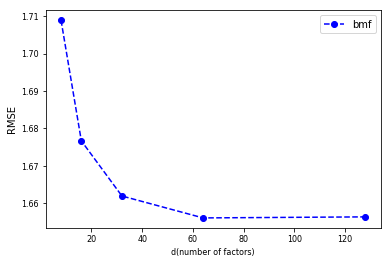

In [58]:
plt.show()

In [142]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

class MSBMF():
    
    def __init__(self, R, Rte, S, D, k, alpha, l, eta, iterations):
        """
        Perform matrix factorization to predict empty
        entries in a matrix.

        L = 0.5 \sum_{u,i} (r_u,i - r'_u,i)^2 + 0.5alpha \sum_{i,j \in n(i, k)} (s_i,j - qiqj)^2 + l * regularization
        
        Arguments
        - R (ndarray)     : user-item rating matrix
        - Rte (ndarray)   : user-item rating matrix for testing
        - S (ndarray)     : song similarity matrix
        - D (int)         : number of latent dimensions
        - k (int)         : k nearest neighbors to consider for any song i 
        - l (float)       : regularization parameter
        - eta (float)     : learning rate
        - alpha (float)   : weight on song similarities
        - iterations (int): No. of iterations to train over
        """
        
        self.R = R
        self.Rte = Rte
        self.S = S
        self.num_users, self.num_items = R.shape
        self.D = D
        self.k = k
        self.l = l
        self.eta = eta
        self.alpha = alpha
        self.iterations = iterations

        nbrs = NearestNeighbors(n_neighbors=self.k + 1).fit(self.S)
        # Does contain itself, hence k + 1
        self.k_distances, self.k_indices = nbrs.kneighbors(self.S)
        


    def train(self):
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./self.D, size=(self.num_users, self.D))
        self.Q = np.random.normal(scale=1./self.D, size=(self.num_items, self.D))
#         print (self.k_distances, self.k_indices)
        
        # Initialize the biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])

        # Similairities are pretrained; is a num_items x num_items matrix
        
        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]
        
        # Perform stochastic gradient descent for number of iterations
        # We use the song similarities in SGD for backprop.
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 10 == 0:
                print("Iteration: %d ; error = %.4f" % (i+1, mse))
        
        return training_process

    def mse(self):
        """
        A function to compute the total mean square error
        """
        xs, ys = self.Rte.nonzero()
        predicted = self.full_matrix()
        error = 0
        count=0
        for x, y in zip(xs, ys):
            err =  pow(self.Rte[x, y] - predicted[x, y], 2)
            if(err>0):
                count += 1
                error += err               
        error = error/count
        return np.sqrt(error)

    def sgd(self):
        """
        Perform stochastic graident descent
        """
        for i, j, r in self.samples:
            # Computer prediction and error
            prediction = self.get_rating(i, j)
            e = (r - prediction)
            
            # Update biases
            self.b_u[i] += self.eta * (e - self.l * self.b_u[i])
            self.b_i[j] += self.eta * (e - self.l * self.b_i[j])
            
            # Update user and item latent feature matrices
            self.P[i, :] += self.eta * (e * self.Q[j, :] - self.l * self.P[i,:])

            # Backprop rule also contains si,j term hiii
            similarity_factor = np.zeros_like(self.Q[j, :])
            for x, d in enumerate(self.k_distances[j]):
                similarity_factor += (d - self.Q[j, :].dot(self.Q[self.k_indices[i][x], :].T)) * (self.Q[self.k_indices[i][x], :])
            self.Q[j, :] += self.eta * (e * self.P[i, :] - self.l * self.Q[j,:] - self.alpha * similarity_factor)

    def get_rating(self, i, j):
        """
        Get the predicted rating of user i and item j
        """
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction
    
    def full_matrix(self):
        """
        Computer the full matrix using the resultant biases, P and Q
        """
        return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)

In [143]:
print test_ratings.shape
sim = np.random.normal(scale=1./8, size=(train_ratings.shape[1], 100))

(41, 20666)


In [145]:
msmf = MSBMF(train_r, test_r, S=sim, D=32,k=3, alpha=1, l=1,eta=0.05, iterations=100)
# R, Rte, S, D, k, alpha, l, eta, iterations)
training_process = msmf.train()
print float(msmf.mse())

(array([[ 0.        ,  0.14379681,  0.17340875,  0.17362662],
       [ 0.        ,  0.22853266,  0.23613412,  0.23915384],
       [ 0.        ,  0.16967936,  0.18710524,  0.19619935],
       ..., 
       [ 0.        ,  0.13866257,  0.16938165,  0.18491857],
       [ 0.        ,  0.15888373,  0.16353202,  0.16452882],
       [ 0.        ,  0.15789037,  0.17252755,  0.17564931]]), array([[    0,  1408, 16604,  4367],
       [    1,  9335,  1473,  2461],
       [    2, 12288, 18976,  7196],
       ..., 
       [20663, 16980,  4000, 10964],
       [20664,  6008, 15429, 12737],
       [20665, 11805, 14154,  9352]]))
Iteration: 10 ; error = 1.7119
Iteration: 20 ; error = 1.7256
Iteration: 30 ; error = 1.7465
Iteration: 40 ; error = 1.7375
Iteration: 50 ; error = 1.7433
Iteration: 60 ; error = 1.7527
Iteration: 70 ; error = 1.7519
Iteration: 80 ; error = 1.7435
Iteration: 90 ; error = 1.7577
Iteration: 100 ; error = 1.7504
1.75040578322
